# Prepare Remote Training

## Run the imagemasks notebook

Run `pipeline/imagemasks.ipynb` to generate the image masks.

## start juypter notebook

```
cd Documents/Workspace/datadev/datagpu && pipenv shell
jupyter notebook --no-browser --NotebookApp.allow_origin='*' --port=8080
```

## start ssh tunnel

```
ssh -NfL localhost:8080:localhost:8080 jack@172.23.0.10
```

## transfer data over

```
scp -r /home/jack/Mounts/DiskOne/kona_coffee/imagemasks jack@172.23.0.10:/home/jack/Documents/kona_coffee

scp /home/jack/Documents/Workspace/kona_coffee/pipeline/classified_masks.csv jack@172.23.0.10:/home/jack/Documents
```

## kill all after finish

```
pkill ssh
```

In [1]:
%%sh
python3 --version

Python 3.10.12


In [15]:
import cv2
import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from tqdm import tqdm

# Suppress warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
sns.set_palette('rainbow')
sns.set_context('talk')

new_basedir = '/home/jack/Documents/kona_coffee/imagemasks'

df = pd.read_csv('/home/jack/Documents/classified_masks.csv')

df['image'] = df['image'].apply(lambda x: os.path.join(new_basedir, os.path.basename(x)))

# filter if they don't exist on disk
df = df[df['image'].apply(lambda x: os.path.exists(x))]

df

,image,lifecycle
0,/home/jack/Documents/kona_coffee/imagemasks/10...,ripening
1,/home/jack/Documents/kona_coffee/imagemasks/10...,ripe
2,/home/jack/Documents/kona_coffee/imagemasks/10...,ripening
3,/home/jack/Documents/kona_coffee/imagemasks/10...,unripe
4,/home/jack/Documents/kona_coffee/imagemasks/10...,unripe
...,...,...
2282,/home/jack/Documents/kona_coffee/imagemasks/10...,ripening
2283,/home/jack/Documents/kona_coffee/imagemasks/10...,unripe
2284,/home/jack/Documents/kona_coffee/imagemasks/10...,unripe
2285,/home/jack/Documents/kona_coffee/imagemasks/10...,unripe


In [17]:
df['lifecycle'].value_counts()

unripe      1371
ripe         532
ripening     384
Name: lifecycle, dtype: int64

In [18]:
# balance the classes by lifecycle
sdf = df.groupby('lifecycle').sample(500, random_state=42, replace=True)

sdf['lifecycle'].value_counts()

ripe        500
ripening    500
unripe      500
Name: lifecycle, dtype: int64

In [19]:
# sample training data
df_train = sdf.sample(frac=0.8, random_state=42)
df_test = sdf.drop(df_train.index)

In [20]:
# load resnet50v2 model trained on imagenet dataset
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow import keras

resnet = ResNet50(
    weights='imagenet',
    include_top=False,
    pooling='avg',
    input_shape=(224, 224, 3)
)

for layer in resnet.layers:
    layer.trainable = False
    
outputs = resnet.layers[-1].output

outputs = Flatten()(outputs)
outputs = Dense(1024, activation='relu')(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(512, activation='relu')(outputs)
outputs = Dense(3, activation='softmax')(outputs)

model = keras.Model(inputs=resnet.inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', 'AUC', 'Precision', 'Recall']
)

In [21]:
# image generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocess(image):
    image = cv2.resize(image, (224, 224))
    image = preprocess_input(image)
    return image

datagen = ImageDataGenerator(
    preprocessing_function=preprocess,
    zoom_range=[0.5, 1.0],
    rotation_range=90,
    brightness_range=[0.2, 1.0],
    horizontal_flip=True,
    vertical_flip=True,
)

train_gen = datagen.flow_from_dataframe(
    df_train,
    directory=None,
    x_col='image',
    y_col='lifecycle',
    target_size=(224, 224),
    class_mode='categorical',
    validation_split=0.2,
    seed=42,
    batch_size=32,
    shuffle=True
)

test_gen = datagen.flow_from_dataframe(
    df_test,
    directory=None,
    x_col='image',
    y_col='lifecycle',
    target_size=(224, 224),
    class_mode='categorical',
    seed=42,
    batch_size=32,
    shuffle=False
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=False
)

# train model
history = model.fit(
    train_gen,
    validation_data=train_gen,
    callbacks=[early_stopping],
    epochs=300,
    verbose=1
)

Found 1200 validated image filenames belonging to 3 classes.
Found 154 validated image filenames belonging to 3 classes.


Epoch 1/300


2023-11-19 13:27:46.988472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


38/38 [==============================] - ETA: 0s - loss: 0.7393 - accuracy: 0.7883 - auc: 0.9243 - precision: 0.7914 - recall: 0.7808

2023-11-19 13:28:04.254964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


38/38 [==============================] - 29s 670ms/step - loss: 0.7393 - accuracy: 0.7883 - auc: 0.9243 - precision: 0.7914 - recall: 0.7808 - val_loss: 0.5336 - val_accuracy: 0.8358 - val_auc: 0.9511 - val_precision: 0.8370 - val_recall: 0.8342
Epoch 2/300
38/38 [==============================] - 22s 588ms/step - loss: 0.4791 - accuracy: 0.8533 - auc: 0.9549 - precision: 0.8546 - recall: 0.8525 - val_loss: 0.3235 - val_accuracy: 0.8758 - val_auc: 0.9746 - val_precision: 0.8764 - val_recall: 0.8742
Epoch 3/300
38/38 [==============================] - 23s 606ms/step - loss: 0.4205 - accuracy: 0.8542 - auc: 0.9629 - precision: 0.8569 - recall: 0.8533 - val_loss: 0.3707 - val_accuracy: 0.8642 - val_auc: 0.9684 - val_precision: 0.8642 - val_recall: 0.8642
Epoch 4/300
38/38 [==============================] - 23s 594ms/step - loss: 0.3699 - accuracy: 0.8625 - auc: 0.9683 - precision: 0.8644 - recall: 0.8608 - val_loss: 0.3282 - val_accuracy: 0.8908 - val_auc: 0.9719 - val_precision: 0.8915 -

In [25]:
model.save('/home/jack/Documents/classify_masks_model.h5')

10


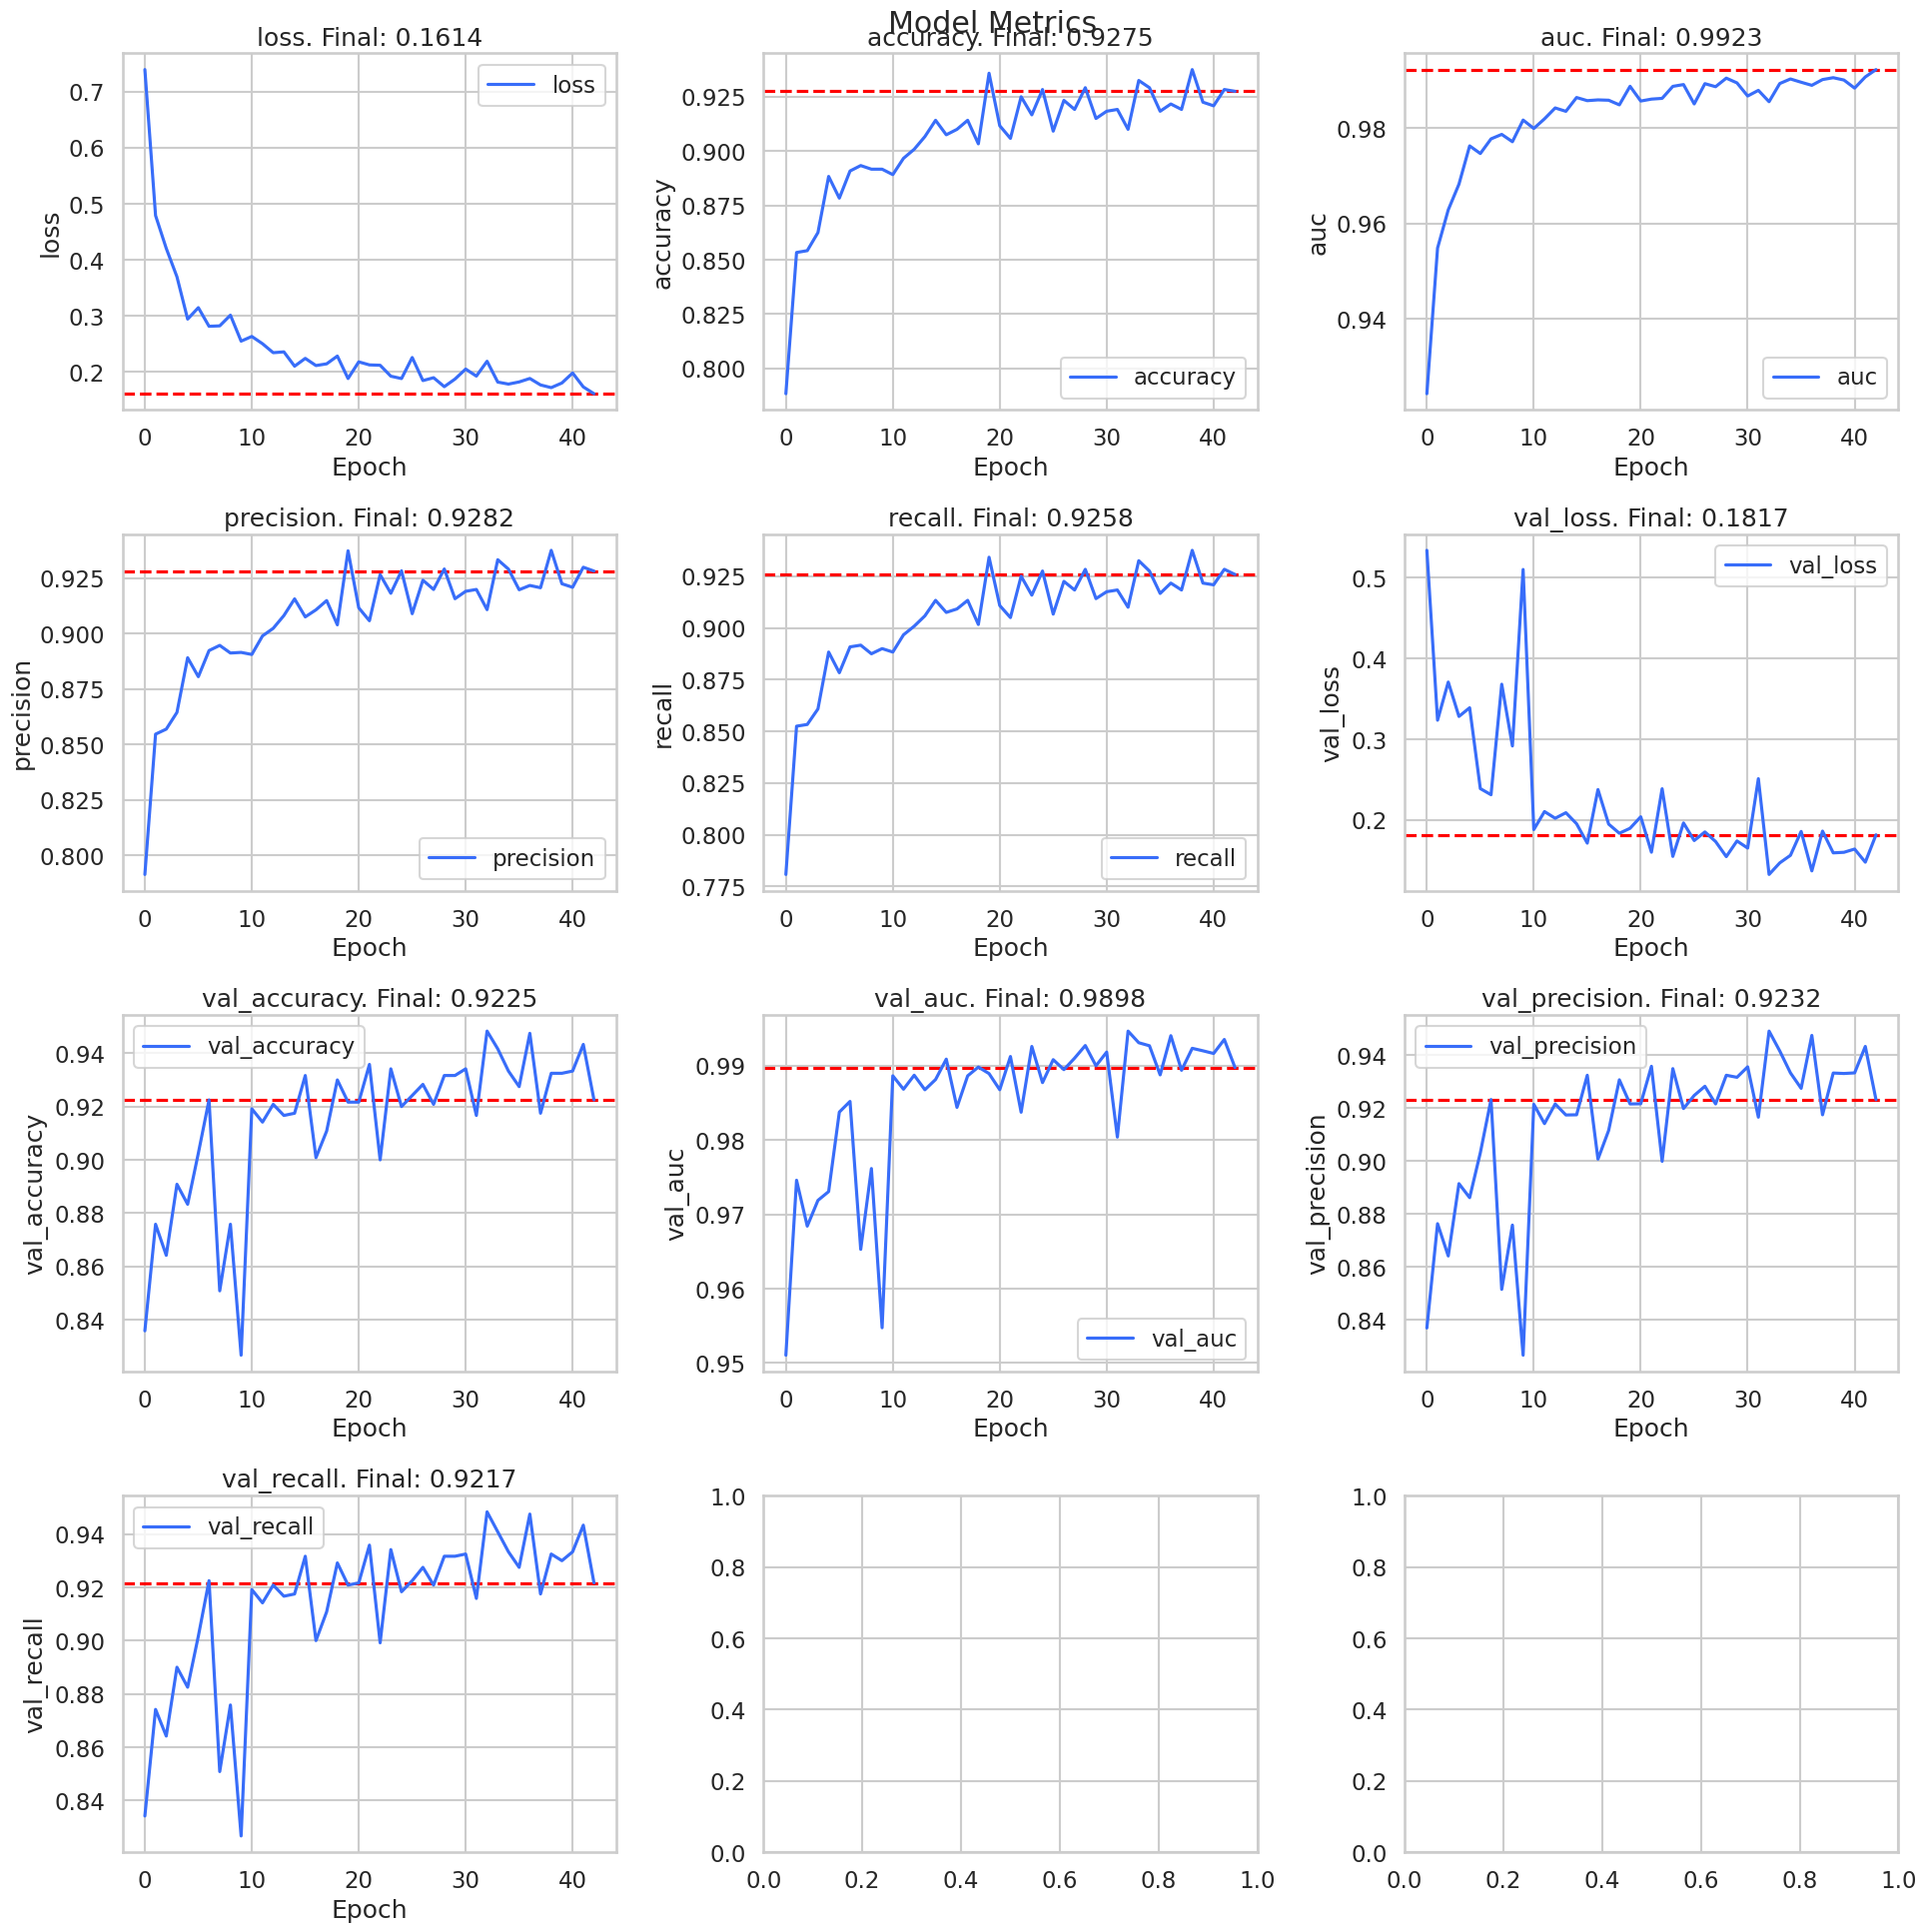

In [23]:
import matplotlib.pyplot as plt

metrics = history.history.keys()

print(len(metrics))

cols = 3
rows = 4

fig, axes = plt.subplots(rows, cols, figsize=(20, 20))
axes = axes.flatten()

# pad the axes
fig.tight_layout(pad=3.0)

fig.suptitle('Model Metrics')

keys = history.history.keys()

for i, key in enumerate(keys):
    
    final_val = history.history[key][-1]
    
    axes[i].axhline(final_val, ls='--', color='r')
    axes[i].plot(history.history[key], label=key)
    axes[i].set_title(f'{key}. Final: {final_val:.4f}')
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel(key)
    axes[i].legend()


Lower precision and higer recall means that the model has a lot of false positives, but it's also finding a lot of true positives. In other words, it's very sensitive, but it's not very precise.

Higher precision and lower recall means that the model has fewer false positives, but it's also missing a lot of true positives. In other words, it's not very sensitive, but when it does make a prediction, it's usually correct.

In [24]:
test = model.evaluate(test_gen, verbose=1)

print(f'Test loss: {test[0]}')
print(f'Test accuracy: {test[1]}')
print(f'Test AUC: {test[2]}')
print(f'Test Precision: {test[3]}')
print(f'Test Recall: {test[4]}')

2023-11-19 13:48:33.507157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


5/5 [==============================] - 4s 788ms/step - loss: 0.2738 - accuracy: 0.9156 - auc: 0.9772 - precision: 0.9156 - recall: 0.9156
Test loss: 0.27378684282302856
Test accuracy: 0.9155844449996948
Test AUC: 0.9772305488586426
Test Precision: 0.9155844449996948
Test Recall: 0.9155844449996948


A test accuracy of 50% on a balanced set of classes means that the model is performing no better than random chance.

In [28]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()